In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import spikeinterface.full as si
import MEArec as mr
import numpy as np
import matplotlib.pyplot as plt
import colorcet as cc
import math
import os
import h5py

def get_ccolor(k):
    if k == -1:
        return "#808080"
    else:
        return ccolors[k % len(ccolors)]
ccolors = cc.glasbey[:31]

In [30]:
from matplotlib.gridspec import GridSpec
# from brainbox.io.one import SpikeSortingLoader
# from ibllib.atlas import AllenAtlas
# from one.api import ONE
# import brainbox.io.one as bbone
import numpy as np
import datetime
from spike_psvae.subtract import read_geom_from_meta
from pathlib import Path
from spike_psvae.waveform_utils import make_channel_index, make_contiguous_channel_index
import matplotlib.pyplot as plt
from spike_psvae import denoise, snr_templates, spike_train_utils
import torch
from spike_psvae.spikeio import read_waveforms

from analysis.data_gen_utils import make_dataset, extract_IBL, extract_sim

In [31]:
# save_path = '/Users/ankit/Documents/PaninskiLab/contrastive_spikes/mearec_v2'
# sim_bin_path = '/Users/ankit/Documents/PaninskiLab/spike-psvae/notebook/Neuropixels-64_static_uniform_homogeneous-001.h5'
# sim_spike_idx, sim_geom, sim_we = extract_sim(sim_bin_path, 1500)
# selected_sim_units = [2, 5, 7, 13, 16, 21, 29, 43, 47, 56]

In [32]:
# make_dataset(sim_bin_path, sim_spike_idx, sim_geom, save_path, sim_we, unit_ids=selected_sim_units, num_chans_extract=1, plot=True)

In [33]:
# save_path = '/Users/ankit/Documents/PaninskiLab/contrastive_spikes/dytest'
# real_bin_path = '/Users/ankit/Documents/PaninskiLab/spike-psvae/notebook/destriped__spikeglx_ephysData_g0_t0.imec0.ap.stream.cbin'
# meta_file = '/Users/ankit/Documents/PaninskiLab/spike-psvae/notebook/destriped__spikeglx_ephysData_g0_t0.imec0.ap.stream.meta'
# pid = 'dab512bd-a02d-4c1f-8dbc-9155a163efc0'
# real_spike_idx, real_geom, chan_idx, temps = extract_IBL(real_bin_path, meta_file, pid, [200, 500])
# selected_real_units = [9, 11, 13, 65, 79, 82, 267, 258, 318, 329]

In [34]:
# make_dataset(real_bin_path, real_spike_idx, real_geom, save_path, chan_index=chan_idx, templates=temps, unit_ids=selected_real_units, plot=True)

In [35]:
# print(real_spike_idx.shape)

In [36]:
# save_path = '/Users/ankit/Documents/PaninskiLab/contrastive_spikes/dytest'
# real_bin_path = '/Users/ankit/Documents/PaninskiLab/spike-psvae/notebook/destriped__spikeglx_ephysData_g0_t0.imec0.ap.stream.cbin'
# meta_file = '/Users/ankit/Documents/PaninskiLab/spike-psvae/notebook/destriped__spikeglx_ephysData_g0_t0.imec0.ap.stream.meta'
# pid = 'febb430e-2d50-4f83-87a0-b5ffbb9a4943'
# real_spike_idx, real_geom, chan_idx, temps = extract_IBL(real_bin_path, meta_file, pid, [0, 600])
# selected_real_units = [9, 11, 13, 65, 79, 82, 267, 258, 318, 329]

In [37]:
import h5py
sub_file = '/moto/stats/users/ch3676/dy_016_raw_ephys_destriped_snippets/subtraction.h5'
with h5py.File(sub_file) as h5:
    spike_index = h5["spike_index"][:]

In [26]:
#load subtraction file from detection
sub_file = '/moto/stats/users/ch3676/dy_016_raw_ephys_destriped_snippets/subtraction.h5'
with h5py.File(sub_file) as h5:
    spike_index = h5["spike_index"][:]

#data and geom paths
data_path = '/moto/stats/users/ch3676/dy_016_raw_ephys_destriped_snippets/'
data_name = 'destriped__spikeglx_ephysData_g0_t0.imec0.ap.stream-002.cbin'
raw_data_bin = Path(data_path + data_name)
geom = np.load("/moto/stats/users/ch3676/datasets_contrastive_ephys/multi_channel/DY016_random_neurons/multi_dy016_random_neurons_04_28_2023/geom.npy")    
geom_dims = (0,1)
output_folder = '/moto/stats/users/ch3676/dy_016_raw_ephys_destriped_snippets/contrastive_dataset'

#get a subset of the data for training, validation, and testing
n_div = 10
num_spikes_train = 1200
num_spikes_val = 100
num_spikes_test = 200
num_spikes_cont = num_spikes_train*n_div + num_spikes_val*n_div + num_spikes_test*n_div

num_spikes_total = spike_index.shape[0]
np.random.seed(0)
spike_indices_cont = np.random.choice(np.arange(num_spikes_total), size=num_spikes_cont)
spike_index_subset = spike_index[spike_indices_cont]

num_chans_extract = 21
train_set, val_set, test_set, train_geom_locs, val_geom_locs, test_geom_locs, train_max_chan, val_max_chan, test_max_chan = make_dataset(raw_data_bin, spike_index_subset, geom, output_folder, geom_dims=geom_dims, train_num=num_spikes_train, val_num=num_spikes_val, test_num=num_spikes_test, do_split=True, plot=True, num_chans_extract=num_chans_extract)

Failed to import IBL packages (brainbox, ibllib, one, brainbox
no unit ids, skipping plotting...
reading waveforms
cropping and storing waveforms
making train, val, test splits
saving final results


In [39]:
#load subtraction file from detection
sub_file = '/moto/stats/users/ch3676/dy_016_raw_ephys_destriped_snippets/subtraction.h5'
with h5py.File(sub_file) as h5:
    spike_index = h5["spike_index"][:]

#data and geom paths
data_path = '/moto/stats/users/ch3676/dy_016_raw_ephys_destriped_snippets/'
data_name = 'destriped__spikeglx_ephysData_g0_t0.imec0.ap.stream-002.cbin'
raw_data_bin = Path(data_path + data_name)
geom = np.load("/moto/stats/users/ch3676/datasets_contrastive_ephys/multi_channel/DY016_random_neurons/multi_dy016_random_neurons_04_28_2023/geom.npy")    
geom_dims = (0,1)
output_folder = '/moto/stats/users/ch3676/dy_016_raw_ephys_destriped_snippets/sw_contrastive_dataset'

#get a subset of the data for training, validation, and testing
n_div = 10
num_spikes_train = 1200
num_spikes_val = 100
num_spikes_test = 200
num_spikes_cont = num_spikes_train*n_div + num_spikes_val*n_div + num_spikes_test*n_div

num_spikes_total = spike_index.shape[0]
np.random.seed(0)
spike_indices_cont = np.random.choice(np.arange(num_spikes_total), size=num_spikes_cont)
spike_index_subset = spike_index[spike_indices_cont]

num_chans_extract = 1
train_set, val_set, test_set, train_geom_locs, val_geom_locs, test_geom_locs, train_max_chan, val_max_chan, test_max_chan = make_dataset(raw_data_bin, spike_index_subset, geom, output_folder, geom_dims=geom_dims, train_num=num_spikes_train, val_num=num_spikes_val, test_num=num_spikes_test, do_split=True, plot=True, num_chans_extract=num_chans_extract)

Failed to import IBL packages (brainbox, ibllib, one, brainbox
no unit ids, skipping plotting...
reading waveforms
cropping and storing waveforms
making train, val, test splits
saving split results


In [63]:
#load subtraction file from detection
sub_file = '/moto/stats/users/ch3676/dy_016_raw_ephys_destriped_snippets/subtraction.h5'
with h5py.File(sub_file) as h5:
    spike_index = h5["spike_index"][:]

#data and geom paths
data_path = '/moto/stats/users/ch3676/dy_016_raw_ephys_destriped_snippets/'
data_name = 'destriped__spikeglx_ephysData_g0_t0.imec0.ap.stream-002.cbin'
raw_data_bin = Path(data_path + data_name)
geom = np.load("/moto/stats/users/ch3676/datasets_contrastive_ephys/multi_channel/DY016_random_neurons/multi_dy016_random_neurons_04_28_2023/geom.npy")    
geom_dims = (0,1)
output_folder = '/moto/stats/users/ch3676/dy_016_raw_ephys_destriped_snippets/infer_contrastive_dataset'

#get a subset of the data for training, validation, and testing
n_div = 10
num_spikes_train = 1200
num_spikes_val = 100
num_spikes_test = 200
num_spikes_cont = num_spikes_train*n_div + num_spikes_val*n_div + num_spikes_test*n_div

num_spikes_total = spike_index.shape[0]
np.random.seed(0)
#
spike_indices_cont = np.random.choice(np.arange(num_spikes_total), size=num_spikes_cont)
spike_index_subset = spike_index[~np.isin(np.arange(len(spike_index)), spike_indices_cont)]
print(spike_index_subset.shape)
num_chans_extract = 21
test_set, test_geom_locs, test_max_chan = make_dataset(raw_data_bin, spike_index_subset, geom, output_folder, geom_dims=geom_dims, train_num=num_spikes_train, val_num=num_spikes_val, test_num=num_spikes_test, do_split=True, plot=True, num_chans_extract=num_chans_extract)

(555446, 2)
no unit ids, skipping plotting...
reading waveforms


MemoryError: Unable to allocate 96.1 GiB for an array with shape (555446, 121, 384) and data type float32

In [60]:
spike_index[spike_indices_cont].shape

(15000, 2)

In [56]:
np.sum(~np.isin(np.arange(len(spike_index)), spike_indices_cont))

555446

In [61]:
spike_index[~np.isin(np.arange(len(spike_index)), spike_indices_cont)].shape

(555446, 2)

In [57]:
15000 + 555446

570446

In [58]:
spike_index.shape

(570263, 2)

Text(0, 0.5, 'Num spikes')

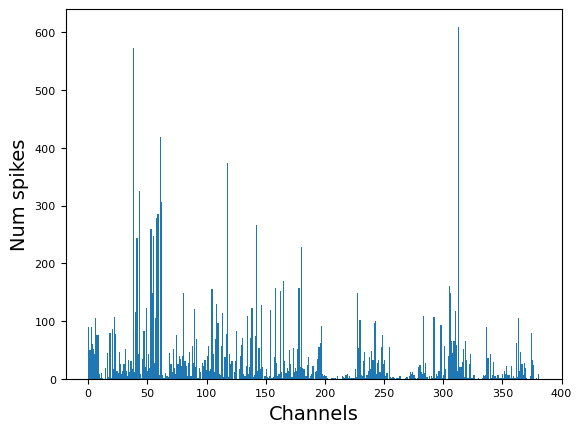

In [40]:
plt.hist(spike_index_subset[:,1], bins=384)
plt.xlabel('Channels')
plt.ylabel('Num spikes')

Text(0, 0.5, 'Num spikes')

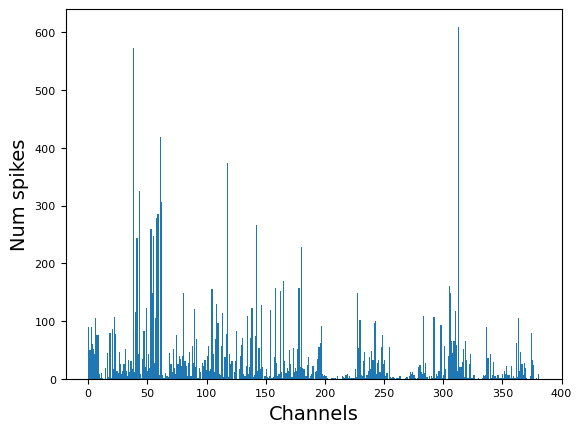

In [157]:
plt.hist(spike_index_subset[:,1], bins=384)
plt.xlabel('Channels')
plt.ylabel('Num spikes')

In [16]:
test_set.shape

(2000, 21, 121)

In [24]:
train_id = 122
print(spike_index_subset[train_id])
print(geom[train_max_chan[train_id].astype('int')])
print(geom[spike_index_subset[train_id][1]])
print(train_geom_locs[train_id][train_geom_locs.shape[1]//2])

[2948505      82]
[[ 43. 740.]
 [ 11. 740.]
 [ 59. 760.]
 [ 27. 760.]
 [ 43. 780.]
 [ 11. 780.]
 [ 59. 800.]
 [ 27. 800.]
 [ 43. 820.]
 [ 11. 820.]
 [ 59. 840.]
 [ 27. 840.]
 [ 43. 860.]
 [ 11. 860.]
 [ 59. 880.]
 [ 27. 880.]
 [ 43. 900.]
 [ 11. 900.]
 [ 59. 920.]
 [ 27. 920.]
 [ 43. 940.]]
[ 59. 840.]
[ 59. 840.]


In [23]:
train_max_chan.shape

(12000, 21)

In [ ]:
ma

In [24]:
train_max_chan[:,0,0] == 0

array([False, False, False, ..., False, False, False])

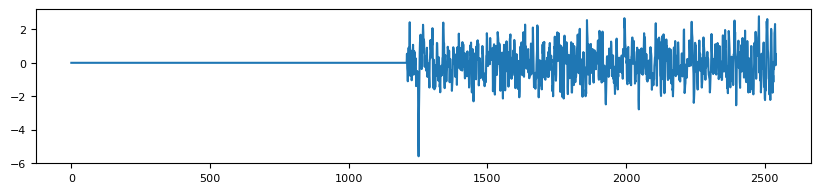

In [31]:
plt.figure(figsize=(10,2))
plt.plot(train_set[train_max_chan[:,0,0] == 0][1].flatten())

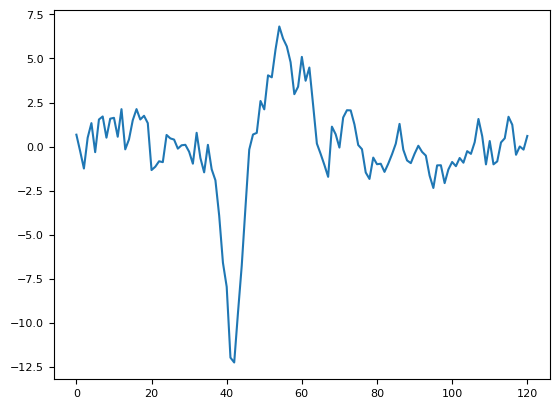

In [43]:
num_extra_chans = 3
wf_id = 5679
wfs_train = train_set[:,train_set.shape[1]//2-num_extra_chans:train_set.shape[1]//2+num_extra_chans+1,:]
plt.plot(wfs_train[wf_id].flatten())

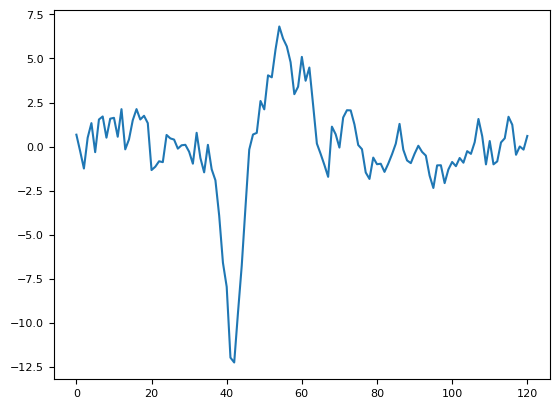

In [42]:
num_extra_chans = 1
wf_id = 5679
wfs_train = train_set[:,train_set.shape[1]//2-num_extra_chans:train_set.shape[1]//2+num_extra_chans+1,:]
plt.plot(wfs_train[wf_id].flatten())

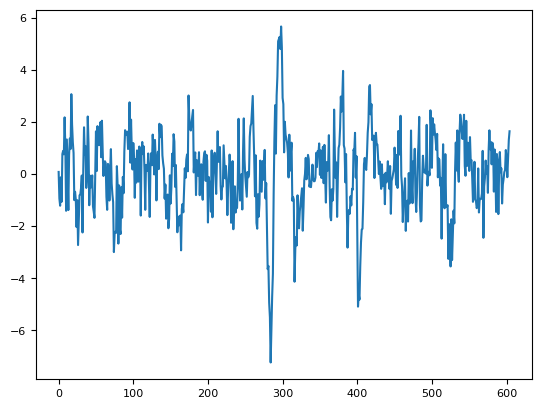

In [159]:
num_extra_chans = 2
wf_id = 5679
wfs_train = train_set[:,train_set.shape[1]//2-num_extra_chans:train_set.shape[1]//2+num_extra_chans+1,:]
plt.plot(wfs_train[wf_id].flatten())

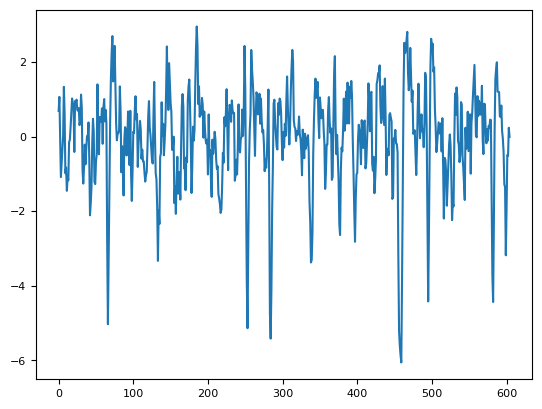

In [170]:
num_extra_chans = 2
wf_id = 11
wfs_train = train_set[:,train_set.shape[1]//2-num_extra_chans:train_set.shape[1]//2+num_extra_chans+1,:]
plt.plot(wfs_train[wf_id].flatten())